# 0.0. IMPORTS

In [1]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import pathlib
import seaborn as sns
import ast
from scipy.stats import chi2_contingency
from category_encoders import TargetEncoder
import lightgbm as lgb
import xgboost as xgb




from geopy.geocoders          import Nominatim
from sqlalchemy               import create_engine, text
from matplotlib               import pyplot as plt
from sklearn.preprocessing    import RobustScaler, MinMaxScaler, LabelEncoder
from boruta                   import BorutaPy
from sklearn.ensemble         import RandomForestRegressor
from sklearn.model_selection  import train_test_split
from sklearn.linear_model     import LinearRegression,  Lasso
from sklearn.metrics          import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score

## 0.1.0 Helper Functions

In [2]:
# função para consultar a api passando as coordenadas
def find_mun( lat,long ):
    
    geolocator = Nominatim(user_agent="Oscar")
    
    lat = str( lat )
    
    long = str( long )
    
    coord = lat + ',' + long

    location = geolocator.reverse( coord  )
    
    if 'city_district' in location.raw['address']:
        
        return location.raw['address']['city_district']
        
    if 'suburb' in location.raw['address']:
            
        return location.raw['address']['suburb']
            
    if 'county' in location.raw['address']:
            
        return location.raw['address']['county']
        
    else:
        
        return 'not found'

  
def stats( df ):
    # separo as feautures numéricas
    num_attributes = df.select_dtypes( include = ['int64','float64'] )

    # separo as features categoricas
    num_categorical = df.select_dtypes( exclude = ['int64','float64','datetime64[ns]'] )


    # medidas de tendencia central - media e mediana
    ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T # media

    ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T # mediana

    # dispersao - std, min , max , range, skew, kurtosis
    d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T # std
    d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T # minimo
    d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T # maximo
    d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T # range
    d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T # skew
    d6 = pd.DataFrame( num_attributes.apply( lambda x : x.kurtosis() ) ).T # kurtosis

    # concatenate - min , max , range,  media, median, std, skew , kurtosis
    m = pd.concat( [ d2 , d3, d4 , ct1 , ct2 , d1,  d5 , d6 ] ).T.reset_index()
    m.columns = [ 'features', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]
    pd.set_option( 'display.float_format', '{:,.2f}'.format )
    return m

def ml_error( model_name, y , y_hat):
    mae =  mean_absolute_error( y , y_hat )
    mape = mean_absolute_percentage_error( y , y_hat )
    rmse = np.sqrt( mean_squared_error( y , y_hat ) )
    r2 =   r2_score(y, y_hat)
    df = pd.DataFrame( {'Model Name ' :  model_name,
                        'MAE' : mae ,
                        'MAPE' : mape,
                        'RMSE' : rmse,
                        'R2_score' : r2  } ,index = [0] )
    
    return df

def remover_outliers( df, coluna ):
    
    linhas_iniciais = df.shape[0] 
    
    #sns.boxplot( df4['price'] )
    d1 = df[coluna].quantile(0.25)
    d3 = df[coluna].quantile(0.75)

    lim_superior = d3 + 1.5*( d3 - d1  )

    lim_inferior = 500
    
    
    df = df.loc[ (df[coluna] >= lim_inferior) & (df[coluna] <= lim_superior) , :  ]
    
    linhas_finais = df.shape[0]
    
    
    print('Foram removidas {}'.format( linhas_iniciais - linhas_finais ) )
          
    return df

def cramer_v( x, y ):
    cm = pd.crosstab( x , y ).values

    n = cm.sum()

    r,k = cm.shape

    chi2 = chi2_contingency( cm )[0]
    chi2corr = max( 0 , chi2 - (k-1) * (r-1) / (n-1) ) # chi2 corrigido
    kcorr = k - (k-1)**2 / (n-1) # k corrigido
    rcorr = r - (k-1)**2 / (n-1) # r corrigido
    
    v = np.sqrt( ( chi2corr/n ) / ( min ( kcorr-1 , rcorr-1 ) )  )
    
    return v

## 0.2.0. Loading Data

In [224]:
# caminho
caminho = pathlib.Path('data')

df = []

for arquivo in caminho.iterdir():
    print(arquivo.name)
    
    # ler o arquivo
    df_read = pd.read_excel( arquivo )
    
    # apender o df
    df.append(df_read)

# concatena os df's
df_raw = pd.concat( df )

df_raw = df_raw[['propertyCode', 'thumbnail', 'numPhotos', 'floor', 'price',
       'propertyType', 'operation', 'size', 'exterior', 'rooms', 'bathrooms',
       'address', 'province', 'municipality', 'district', 'country',
       'latitude', 'longitude', 'showAddress', 'url', 'distance',
       'description', 'hasVideo', 'status', 'newDevelopment', 'hasLift',
       'priceByArea', 'detailedType', 'suggestedTexts', 'hasPlan', 'has3DTour',
       'has360', 'hasStaging', 'topNewDevelopment', 'superTopHighlight',
       'parkingSpace', 'externalReference', 'labels', 'neighborhood', 'pagina',
       'datetime_scrapy', 'newDevelopmentFinished', 'highlight']]

# resetar index
df_raw = df_raw.reset_index( drop = True )

extracao_12_4_2023.xlsx
extracao_1_1_2023.xlsx
extracao_1_9_2023.xlsx
extracao_2_2_2023.xlsx
extracao_2_6_2023.xlsx
extracao_3_3_2023.xlsx
extracao_6_7_2023.xlsx


In [255]:
df_raw.columns

Index(['propertyCode', 'thumbnail', 'numPhotos', 'floor', 'price',
       'propertyType', 'operation', 'size', 'exterior', 'rooms', 'bathrooms',
       'address', 'province', 'municipality', 'district', 'country',
       'latitude', 'longitude', 'showAddress', 'url', 'distance',
       'description', 'hasVideo', 'status', 'newDevelopment', 'hasLift',
       'priceByArea', 'detailedType', 'suggestedTexts', 'hasPlan', 'has3DTour',
       'has360', 'hasStaging', 'topNewDevelopment', 'superTopHighlight',
       'parkingSpace', 'externalReference', 'labels', 'neighborhood', 'pagina',
       'datetime_scrapy', 'newDevelopmentFinished', 'highlight'],
      dtype='object')

## 0.2.1 Separar Dados de Teste

In [226]:
# Separar Dados de Teste
divisor = df_raw.shape[0] - 1000
df_teste = df_raw.iloc[ divisor: ] # pego 1000 linhas para teste

In [228]:
# separar dados brutos
df_raw = df_raw.iloc[:divisor]

# 1.0. PASSO 01 - DESCRIÇÃO DOS DADOS

In [7]:
df1 = df_raw.copy()

## Explicação das colunas

* property_code - ID unico para cada imovel


* thumbnail - mostra a thumbnail do imovel


* external_reference - A feature "external_reference" geralmente se refere a um código único atribuído a um imóvel por outra fonte, como outra plataforma imobiliária ou um agente imobiliário. Essa referência externa pode ser usada para rastrear e identificar o imóvel em diferentes sistemas e plataformas.


* num_photos - número de fotos do anúncio


* price - preço da renda


* property_type - tipo de propriedade


* operation - renda ou venda ( nesse caso tenho somente renda )


* size - tamanho em m2


* exterior - deve ser se o imóvel tem área exterior ( array([ 0., nan]) 


* rooms - quantidade de quartos


* bathrooms - quantidade de casas de banho


* address - endereço do imóvel


* province - são as regiões ( Lisboa, Setúbal, Santarém - vieram na extração )


* municipality - municipios


* district - são os Distritos


* country - PT 


* latitude - latitude


* longitude - longitude


* show_address - boolean - se o anunciante exibe o endereço


* url - a url do anuncio


* distance - distancia do centro em m


* description - descricao do apartamento


* has_video - diz se o anuncio tem vídeo ou não ( array([ 0.,  1., nan]) )


* status - diz sobre o estado do imóvel array(['good', 'renew', 'newdevelopment', None], dtype=object)


* new_development - boolean - diz se o empreendimento é novo ou não 


* price_by_area - preco divido pelo tamanho do imóvel price / size


* detailed_type - descrição detalhada do tipo de imóvel


* suggested_texts - títulos e subtítulos


* has_plan - se o imóvel tem plano ou não


* has3_d_tour - indica se o imóvel tem tour 3d


* has360 - se tem tour 360º


* has_staging - se tem uma decoração na propriedade


* top_new_development - indica os empreendimentos mais novos


* super_top_highlight - indica os imóveis mais valiosos ou populares em uma determinada área


* floor - indica o andar do imóvel


* has_lift - indica se tem elevador


* parking_space - indica se tem vaga de garagem


* neighborhood - Essa feature é útil para compradores e inquilinos que têm preferência por um determinado bairro ou querem morar em uma área específica da cidade por motivos como proximidade do trabalho, escolas, transporte público, entre outros.


* labels - etiquetas ou rótulos associados aos imoveis


* pagina - a pagina da extração ( definida na extração )


* datetime_scrapy - indica a data da extração ( definida na extração )


* newDevelopmentFinished - 


* highlight - 

## 1.1. Rename Columns

In [8]:
cols_old = [ 'propertyCode', 'thumbnail', 'numPhotos', 'floor', 'price',
       'propertyType', 'operation', 'size', 'exterior', 'rooms', 'bathrooms',
       'address', 'province', 'municipality', 'district', 'country',
       'latitude', 'longitude', 'showAddress', 'url', 'distance',
       'description', 'hasVideo', 'status', 'newDevelopment', 'hasLift',
       'priceByArea', 'detailedType', 'suggestedTexts', 'hasPlan', 'has3DTour',
       'has360', 'hasStaging', 'topNewDevelopment', 'superTopHighlight',
       'parkingSpace', 'externalReference', 'labels', 'neighborhood', 'pagina',
       'datetime_scrapy', 'newDevelopmentFinished', 'highlight']

# def função snake_case
snake_case = lambda x: inflection.underscore( x )

# defino as novas colunas
cols_new = list( map( snake_case, cols_old ) )

df1.columns = cols_new

## 1.2. Data Dimensions

In [9]:
print( 'Number of rows {:,}'.format( df1.shape[0] ) )
print( 'Number of columns {:,}'.format( df1.shape[1] ) )

Number of rows 12,841
Number of columns 43


## 1.3. Data Types

In [10]:
# exibindo os tipos de dados
print( df1.dtypes )

property_code                 int64
thumbnail                    object
num_photos                    int64
floor                        object
price                         int64
property_type                object
operation                    object
size                        float64
exterior                     object
rooms                         int64
bathrooms                     int64
address                      object
province                     object
municipality                 object
district                     object
country                      object
latitude                    float64
longitude                   float64
show_address                   bool
url                          object
distance                      int64
description                  object
has_video                      bool
status                       object
new_development                bool
has_lift                    float64
price_by_area                 int64
detailed_type               

## 1.4. Check NA

In [11]:
df1.isna().sum()

property_code                   0
thumbnail                      29
num_photos                      0
floor                        5598
price                           0
property_type                   0
operation                       0
size                            0
exterior                     2581
rooms                           0
bathrooms                       0
address                         0
province                        0
municipality                    0
district                     1560
country                         0
latitude                        0
longitude                       0
show_address                    0
url                             0
distance                        0
description                    14
has_video                       0
status                          0
new_development                 0
has_lift                     4004
price_by_area                   0
detailed_type                   0
suggested_texts                 0
has_plan      

## 1.5. Fillout NA

In [12]:
# thumbnail - vou substituir anúncios que possuem thumbnail por 1 e aqueles que não por 0
df1['thumbnail'] = np.where( df1['thumbnail'].isna(), 0 , 1 )

# floor 
df1['floor'] = df1['floor'].apply( lambda x : 0 if pd.isna( x ) else x )

# district - vou fazer uma chamada na api para procurar os districts passando as coordenadas
df1['district'] = df1.apply(lambda x: find_mun( x['latitude'], x['longitude'] ) if pd.isna( x['district'] ) else x['district'],axis = 1)

# description
df1['description'] = df1['description'].apply( lambda x : 'no description' if pd.isna( x ) else x )

# has_lift - vou considerar que se não foi informado na base o apto imovel não tem elevador
df1['has_lift'] = df1['has_lift'].apply( lambda x: 0 if pd.isna( x ) else x  )

# parking_space 
df1['parking_space'] = df1['parking_space'].apply( lambda x: 0 if pd.isna( x ) else x ) 

## 1.5.1 - Excluindo colunas irrelevantes

In [13]:
# colunas vazias ou irrelevantes
colunas = ['external_reference',
           'labels',
           'neighborhood',
           'new_development_finished',
           'highlight', 
           'has_staging',
           'top_new_development',
           'exterior',
           'super_top_highlight',
           'operation',
           'country',
           'url',
           'price_by_area']

df1 = df1.drop( labels = colunas , axis = 1 )

## 1.7. Descriptive Statistical

## 1.7.1 Numerical Attributes

In [14]:
df1_stats = stats( df1 )
df1_stats

,features,min,max,range,mean,median,std,skew,kurtosis
0,property_code,"27,208,296.00","32,861,516.00","5,653,220.00","32,357,007.20","32,483,819.00","615,888.83",-3.92,19.39
1,num_photos,0.00,180.00,180.00,25.47,24.00,13.00,1.61,6.31
2,price,300.00,"80,000.00","79,700.00","3,127.27","2,200.00","3,029.70",4.52,49.12
3,size,10.00,"7,000.00","6,990.00",153.17,116.00,177.02,20.13,716.75
4,rooms,0.00,21.00,21.00,2.65,2.00,1.44,1.76,11.46
5,bathrooms,1.00,14.00,13.00,2.16,2.00,1.31,1.94,6.80
6,latitude,38.44,39.16,0.72,38.73,38.72,0.07,1.13,8.12
7,longitude,-9.49,-8.62,0.87,-9.21,-9.16,0.13,-0.15,0.05
8,distance,61.00,"49,855.00","49,794.00","11,101.00","6,606.00","10,410.39",0.84,-0.32
9,has_lift,0.00,1.00,1.00,0.47,0.00,0.50,0.11,-1.99


## 1.7.2 Categorical Attributes

In [15]:
df1['province'] = df1['province'].apply( lambda x : 'Lisboa' if x == 'lisboa' else 'Setúbal' if x == 'setubal' else 'Santarém' if x == 'santarem'  else x)

num_categorical = df1.select_dtypes( exclude = ['int64','float64','datetime64[ns]'] )
# verifico quantos tipos diferentes tenho nas var categoricas
print( num_categorical.apply( lambda x: x.unique().shape[0] ) )

print( '='*100 )

# verifico quantos tipos diferentes tenho nas var categoricas
print( num_categorical.apply( lambda x: x.unique() ) )

thumbnail             2
floor                30
property_type         6
address            3253
province              3
municipality        140
district            383
show_address          2
description        8878
has_video             2
status                3
new_development       2
detailed_type        15
suggested_texts    3556
has_plan              2
has3_d_tour           2
has360                2
parking_space        11
datetime_scrapy      86
dtype: int64
thumbnail                                                     [1, 0]
floor              [6, 2, bj, 0, 1, 3, 8, 5, 4, 7, 9, en, 16, 12,...
property_type      [flat, chalet, duplex, studio, penthouse, coun...
address            [Nova Carnaxide, Rua Professor Doutor João Bat...
province                                 [Lisboa, Setúbal, Santarém]
municipality       [Carnaxide e Queijas, Rio de Mouro, Carnide, M...
district           [Nova Carnaxide, Vale Mourão - Paiões, Carnide...
show_address                                    

# 2.0 Feature Engineering

In [16]:
df2 = df1.copy()

In [17]:
# mes
df2['datetime_scrapy'] = pd.to_datetime( df2['datetime_scrapy'] )
df2['month'] = df2['datetime_scrapy'].dt.month 

# ano
df2['year'] = df2['datetime_scrapy'].dt.year

# excluir a coluna datetime
df2 = df2.drop( 'datetime_scrapy', axis = 1 )

# 3.0 Filtragem de Variáveis

In [18]:
df3 = df2.copy()

In [19]:
# Vou querer saber somente os preços na province de Lisboa
df3 = df3.loc[ df3['province'] == 'Lisboa' , :  ]

# vou querer somente as habitações que tenham de 0 a no máximo 4 quartos
df3 = df3.loc[ df3['rooms'].isin( [ 0,1,2,3,4 ] ) , : ]

colunas =[ 'property_code','pagina' ]

df3 = df3.drop( colunas , axis = 1 )


# 4.0 Análise Exploratória de Dados

In [20]:
df4 = df3.copy()

## 4.1. - Analise Univariada

In [21]:
# verifico as informações estatísticas
stats( df4 )

,features,min,max,range,mean,median,std,skew,kurtosis
0,num_photos,0.00,119.00,119.00,24.69,23.00,11.84,1.31,3.60
1,price,500.00,"80,000.00","79,500.00","2,810.10","2,200.00","2,332.25",6.35,128.10
2,size,10.00,"1,040.00","1,030.00",128.58,110.00,79.86,2.50,12.66
3,rooms,0.00,4.00,4.00,2.36,2.00,1.03,-0.09,-0.66
4,bathrooms,1.00,7.00,6.00,1.97,2.00,1.00,1.14,1.38
5,latitude,38.68,39.15,0.48,38.74,38.72,0.06,3.41,13.98
6,longitude,-9.49,-8.86,0.63,-9.22,-9.17,0.11,-0.71,-0.65
7,distance,61.00,"49,801.00","49,740.00","9,817.88","5,261.00","10,046.95",1.07,0.17
8,has_lift,0.00,1.00,1.00,0.52,1.00,0.50,-0.06,-2.00
9,month,1.00,9.00,8.00,5.05,4.00,2.64,0.19,-1.17


### 4.1.1 - Response Variable

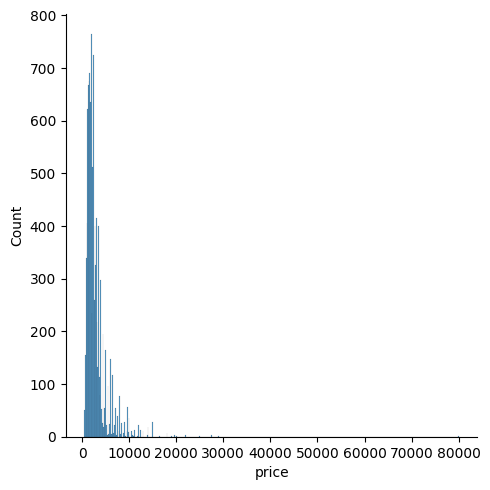

In [22]:
# variavael resposta normal
sns.displot( df4['price'] )

Foram removidas 843


<Axes: >

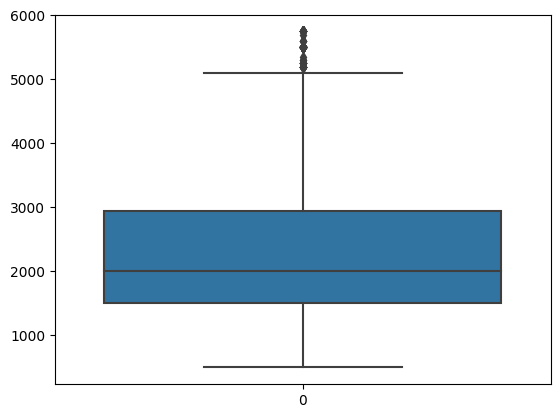

In [23]:
# variavel resposta sem outliers
df4 = remover_outliers( df4 , 'price' )
sns.boxplot( df4['price'] )

### 4.1.2 - Numerical Variable

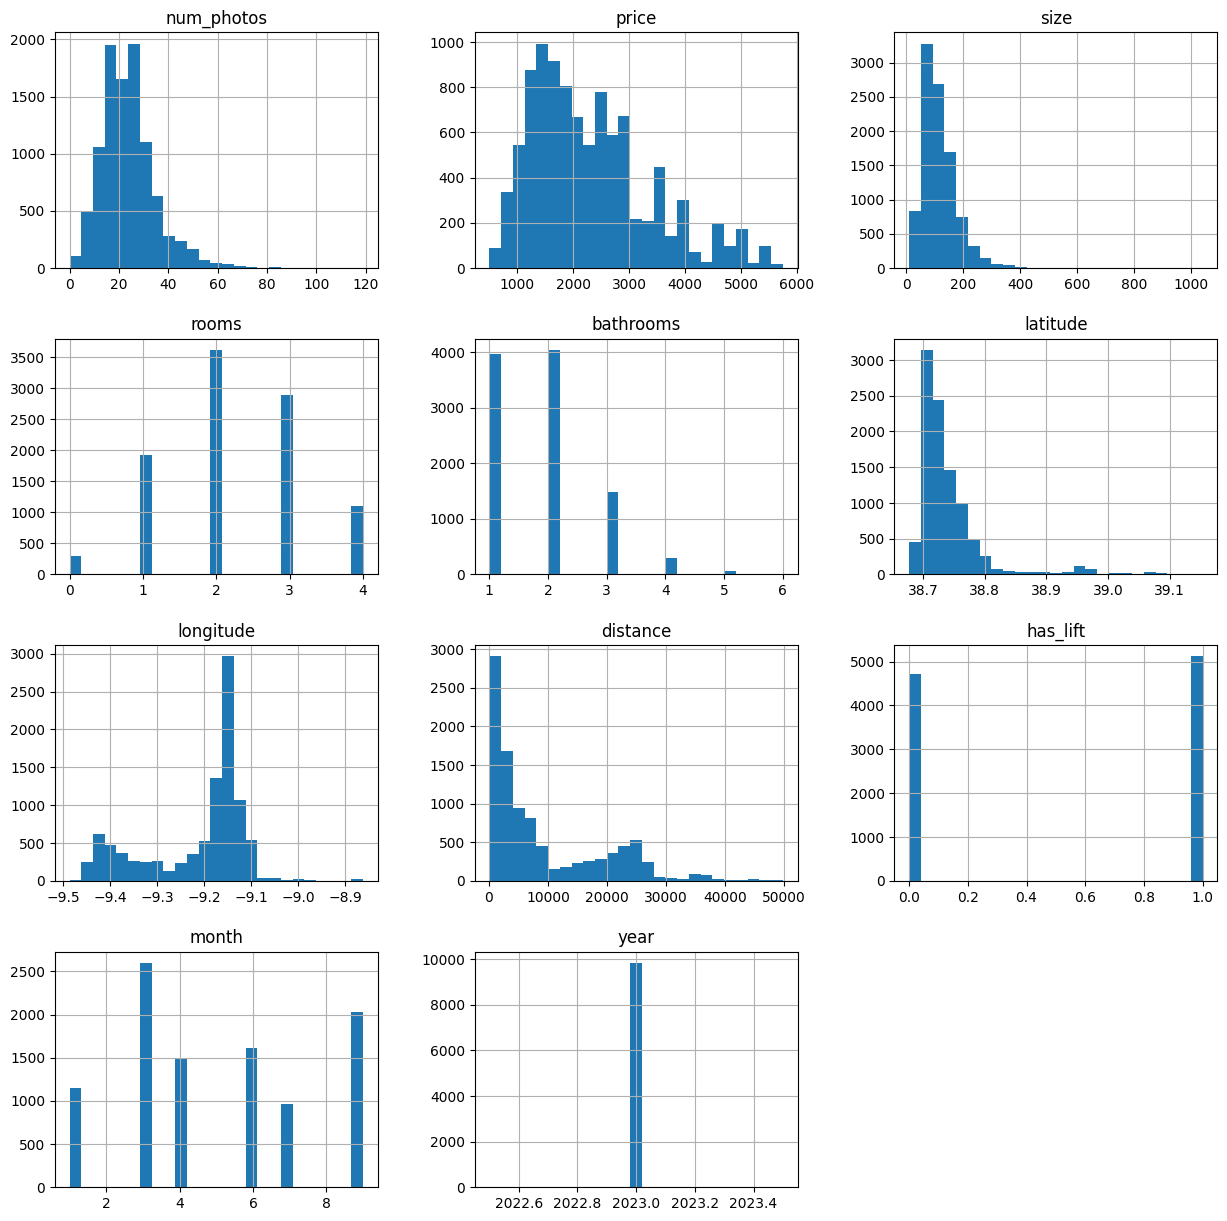

In [24]:
df4_num_attributes = df4.select_dtypes( include = ['int64','float64'] )
df4_num_attributes.hist( bins = 25, figsize=( 15,15 ) );

## 4.2. -  Análise Bivariada

### 4.2.1 - Correlação entre Atributos Numéricos

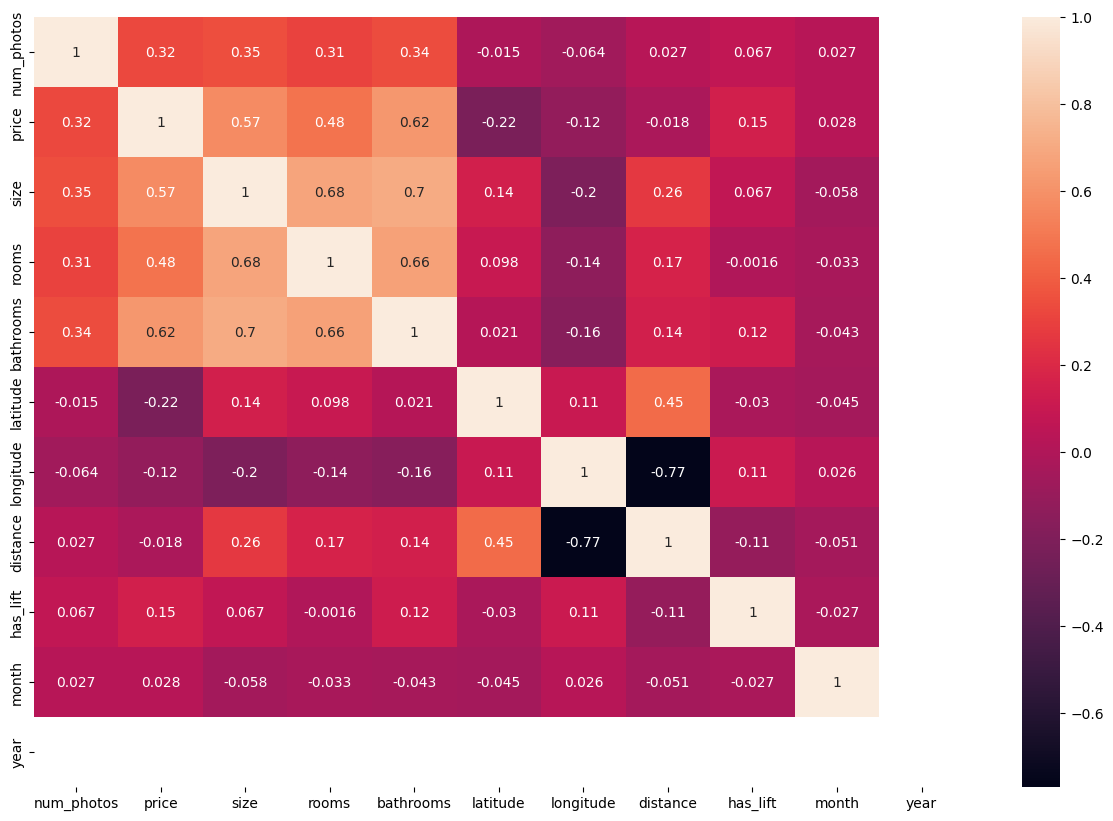

In [25]:
plt.figure( figsize = (15,10) )
correlation = df4_num_attributes.corr( method = 'pearson' )
sns.heatmap( correlation, annot = True );

### 4.2.2 - Correlação entre Atributos Categóricos

In [26]:
a = df4.select_dtypes( include = ['object'] ) # pego o df mais atualizado

# aplico a função cramer v nas variáveis categoricas
a1 = cramer_v( a['floor'] , a['floor'] )
a2 = cramer_v( a['floor'], a['property_type'] )
a3 = cramer_v( a['floor'], a['address'] )
a4 = cramer_v( a['floor'], a['province'] )
a5 = cramer_v( a['floor'], a['municipality'] )
a6 = cramer_v( a['floor'], a['district'] )
a7 = cramer_v( a['floor'], a['description'] )
a8 = cramer_v( a['floor'], a['status'] )
a9 = cramer_v( a['floor'], a['detailed_type'] )
a10 = cramer_v( a['floor'], a['suggested_texts'] )
a11 = cramer_v( a['floor'], a['parking_space'] )

# aplico a função cramer v nas variáveis categoricas
a12= cramer_v( a['property_type'], a['floor'] )
a13= cramer_v( a['property_type'], a['property_type'] )
a14= cramer_v( a['property_type'], a['address'] )
a15= cramer_v( a['property_type'], a['province'] )
a16= cramer_v( a['property_type'], a['municipality'] )
a17= cramer_v( a['property_type'], a['district'] )
a18= cramer_v( a['property_type'], a['description'] )
a19= cramer_v( a['property_type'], a['status'] )
a20= cramer_v( a['property_type'], a['detailed_type'] )
a21=cramer_v(  a['property_type'], a['suggested_texts'] )
a22=cramer_v(  a['property_type'], a['parking_space'] )

# aplico a função cramer v nas variáveis categoricas
a23= cramer_v( a['address'], a['floor'] )
a24= cramer_v( a['address'], a['property_type'] )
a25= cramer_v( a['address'], a['address'] )
a26= cramer_v( a['address'], a['province'] )
a27= cramer_v( a['address'], a['municipality'] )
a28= cramer_v( a['address'], a['district'] )
a29= cramer_v( a['address'], a['description'] )
a30= cramer_v( a['address'], a['status'] )
a31= cramer_v( a['address'], a['detailed_type'] )
a32=cramer_v(  a['address'], a['suggested_texts'] )
a33=cramer_v(  a['address'], a['parking_space'] )

# aplico a função cramer v nas variáveis categoricas
a34= cramer_v( a['province'], a['floor'] )
a35= cramer_v( a['province'], a['property_type'] )
a36= cramer_v( a['province'], a['address'] )
a37= cramer_v( a['province'], a['province'] )
a38= cramer_v( a['province'], a['municipality'] )
a39= cramer_v( a['province'], a['district'] )
a40= cramer_v( a['province'], a['description'] )
a41= cramer_v( a['province'], a['status'] )
a42= cramer_v( a['province'], a['detailed_type'] )
a43=cramer_v(  a['province'], a['suggested_texts'] )
a44=cramer_v(  a['province'], a['parking_space'] )

# aplico a função cramer v nas variáveis categoricas
a45= cramer_v( a['municipality'], a['floor'] )
a46= cramer_v( a['municipality'], a['property_type'] )
a47= cramer_v( a['municipality'], a['address'] )
a48= cramer_v( a['municipality'], a['province'] )
a49= cramer_v( a['municipality'], a['municipality'] )
a50= cramer_v( a['municipality'], a['district'] )
a51= cramer_v( a['municipality'], a['description'] )
a52= cramer_v( a['municipality'], a['status'] )
a53= cramer_v( a['municipality'], a['detailed_type'] )
a54=cramer_v(  a['municipality'], a['suggested_texts'] )
a55=cramer_v(  a['municipality'], a['parking_space'] )

# aplico a função cramer v nas variáveis categoricas
a56= cramer_v( a['district'], a['floor'] )
a57= cramer_v( a['district'], a['property_type'] )
a58= cramer_v( a['district'], a['address'] )
a59= cramer_v( a['district'], a['province'] )
a60= cramer_v( a['district'], a['municipality'] )
a61= cramer_v( a['district'], a['district'] )
a62= cramer_v( a['district'], a['description'] )
a63= cramer_v( a['district'], a['status'] )
a64= cramer_v( a['district'], a['detailed_type'] )
a65=cramer_v(  a['district'], a['suggested_texts'] )
a66=cramer_v(  a['district'], a['parking_space'] )

# aplico a função cramer v nas variáveis categoricas
a67= cramer_v( a['description'], a['floor'] )
a68= cramer_v( a['description'], a['property_type'] )
a69= cramer_v( a['description'], a['address'] )
a70= cramer_v( a['description'], a['province'] )
a71= cramer_v( a['description'], a['municipality'] )
a72= cramer_v( a['description'], a['district'] )
a73= cramer_v( a['description'], a['description'] )
a74= cramer_v( a['description'], a['status'] )
a75= cramer_v( a['description'], a['detailed_type'] )
a76=cramer_v(  a['description'], a['suggested_texts'] )
a77=cramer_v(  a['description'], a['parking_space'] )

# aplico a função cramer v nas variáveis categoricas
a78= cramer_v( a['status'], a['floor'] )
a79= cramer_v( a['status'], a['property_type'] )
a80= cramer_v( a['status'], a['address'] )
a81= cramer_v( a['status'], a['province'] )
a82= cramer_v( a['status'], a['municipality'] )
a83= cramer_v( a['status'], a['district'] )
a84= cramer_v( a['status'], a['description'] )
a85= cramer_v( a['status'], a['status'] )
a86= cramer_v( a['status'], a['detailed_type'] )
a87=cramer_v(  a['status'], a['suggested_texts'] )
a88=cramer_v(  a['status'], a['parking_space'] )

# aplico a função cramer v nas variáveis categoricas
a89= cramer_v( a['detailed_type'], a['floor'] )
a90= cramer_v( a['detailed_type'], a['property_type'] )
a91= cramer_v( a['detailed_type'], a['address'] )
a92= cramer_v( a['detailed_type'], a['province'] )
a93= cramer_v( a['detailed_type'], a['municipality'] )
a94= cramer_v( a['detailed_type'], a['district'] )
a95= cramer_v( a['detailed_type'], a['description'] )
a96= cramer_v( a['detailed_type'], a['status'] )
a97= cramer_v( a['detailed_type'], a['detailed_type'] )
a98=cramer_v(  a['detailed_type'], a['suggested_texts'] )
a99=cramer_v(  a['detailed_type'], a['parking_space'] )

# aplico a função cramer v nas variáveis categoricas
a100= cramer_v( a['suggested_texts'], a['floor'] )
a101= cramer_v( a['suggested_texts'], a['property_type'] )
a102= cramer_v( a['suggested_texts'], a['address'] )
a103= cramer_v( a['suggested_texts'], a['province'] )
a104= cramer_v( a['suggested_texts'], a['municipality'] )
a105= cramer_v( a['suggested_texts'], a['district'] )
a106= cramer_v( a['suggested_texts'], a['description'] )
a107= cramer_v( a['suggested_texts'], a['status'] )
a108= cramer_v( a['suggested_texts'], a['detailed_type'] )
a109=cramer_v(  a['suggested_texts'], a['suggested_texts'] )
a110=cramer_v(  a['suggested_texts'], a['parking_space'] )

# aplico a função cramer v nas variáveis categoricas
a111= cramer_v( a['parking_space'], a['floor'] )
a112= cramer_v( a['parking_space'], a['property_type'] )
a113= cramer_v( a['parking_space'], a['address'] )
a114= cramer_v( a['parking_space'], a['province'] )
a115= cramer_v( a['parking_space'], a['municipality'] )
a116= cramer_v( a['parking_space'], a['district'] )
a117= cramer_v( a['parking_space'], a['description'] )
a118= cramer_v( a['parking_space'], a['status'] )
a119= cramer_v( a['parking_space'], a['detailed_type'] )
a120=cramer_v(  a['parking_space'], a['suggested_texts'] )
a121=cramer_v(  a['parking_space'], a['parking_space'] )



d = pd.DataFrame( {'floor' : [a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11],
                   'property_type' : [a12,a13,a14,a15,a16,a17,a18,a19,a20,a21,a22],
                   'address' : [a23,a24,a25,a26,a27,a28,a29,a30,a31,a32,a33],
                   'province' : [a34,a35,a36,a37,a38,a39,a40,a41,a42,a43,a44],
                   'municipality' : [a45,a46,a47,a48,a49,a50,a51,a52,a53,a54,a55],
                   'district' : [a56,a57,a58,a59,a60,a61,a62,a63,a64,a65,a66],
                   'description' : [a67,a68,a69,a70,a71,a72,a73,a74,a75,a76,a77],
                   'status' : [a78,a79,a80,a81,a82,a83,a84,a85,a86,a87,a88],
                   'detailed_type' : [a89,a90,a91,a92,a93,a94,a95,a96,a97,a98,a99],
                   'suggested_texts' : [a100,a101,a102,a103,a104,a105,a106,a107,a108,a109,a110],
                   'parking_space' : [a111,a112,a113,a114,a115,a116,a117,a118,a119,a120,a121]
              
              } )

d = d.set_index( d.columns )
d = d.drop( 'province', axis = 1 )

C:\Users\oscar\AppData\Local\Temp\ipykernel_6448\1974050943.py:105: RuntimeWarning: invalid value encountered in sqrt
  v = np.sqrt( ( chi2corr/n ) / ( min ( kcorr-1 , rcorr-1 ) )  )
C:\Users\oscar\AppData\Local\Temp\ipykernel_6448\1974050943.py:105: RuntimeWarning: invalid value encountered in double_scalars
  v = np.sqrt( ( chi2corr/n ) / ( min ( kcorr-1 , rcorr-1 ) )  )
C:\Users\oscar\AppData\Local\Temp\ipykernel_6448\1974050943.py:105: RuntimeWarning: invalid value encountered in sqrt
  v = np.sqrt( ( chi2corr/n ) / ( min ( kcorr-1 , rcorr-1 ) )  )
C:\Users\oscar\AppData\Local\Temp\ipykernel_6448\1974050943.py:105: RuntimeWarning: invalid value encountered in sqrt
  v = np.sqrt( ( chi2corr/n ) / ( min ( kcorr-1 , rcorr-1 ) )  )
C:\Users\oscar\AppData\Local\Temp\ipykernel_6448\1974050943.py:105: RuntimeWarning: invalid value encountered in sqrt
  v = np.sqrt( ( chi2corr/n ) / ( min ( kcorr-1 , rcorr-1 ) )  )
C:\Users\oscar\AppData\Local\Temp\ipykernel_6448\1974050943.py:105: Runtime

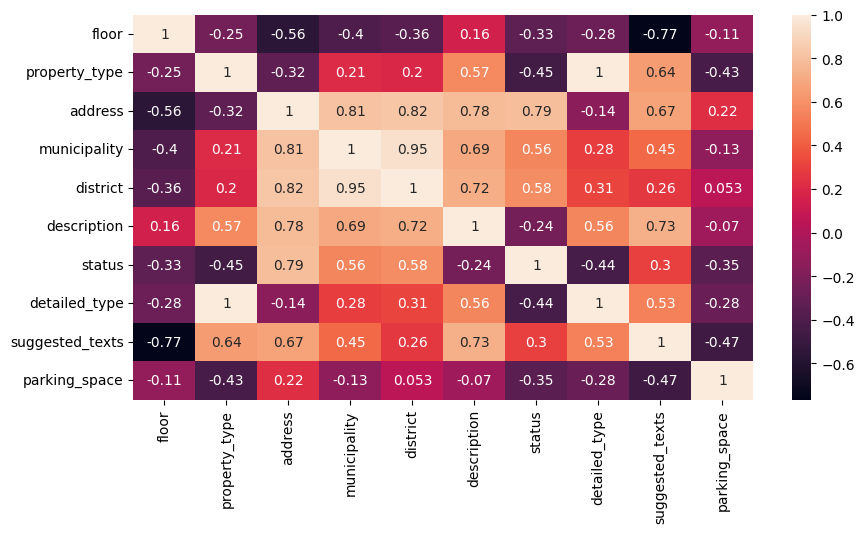

In [27]:
plt.figure(figsize=(10,5))
correlation = d.corr( method = 'pearson' )
sns.heatmap( correlation, annot = True );

# Data Preparation

In [230]:
df5 = df4.copy()

In [231]:
df5.columns

Index(['thumbnail', 'num_photos', 'floor', 'price', 'property_type', 'size',
       'rooms', 'bathrooms', 'address', 'province', 'municipality', 'district',
       'latitude', 'longitude', 'show_address', 'distance', 'description',
       'has_video', 'status', 'new_development', 'has_lift', 'detailed_type',
       'suggested_texts', 'has_plan', 'has3_d_tour', 'has360', 'parking_space',
       'month', 'year'],
      dtype='object')

## 5.1. - Rescaling

In [29]:
# rs = RobustScaler() # usado para variáveis que tem outliers
# mms = MinMaxScaler() 

# # distance
# df5['distance'] = mms.fit_transform( df5[['distance']].values )

In [30]:
# sns.displot( df5['distance']  )

# 5.2 Encoding 

In [232]:
# floor - substituo os andares com letras
df5['floor'] = df5['floor'].replace( ['bj','st','ss','en'], 0 )

# transformo em inteiros
df5['floor'] = df5['floor'].astype( 'int64' )

#property_type - frequency enconding
label_encoder = LabelEncoder()

df5['property_type'] = label_encoder.fit_transform( df5['property_type'] )
df5['address'] = label_encoder.fit_transform( df5['address'] )
df5['district'] = label_encoder.fit_transform( df5['district'] )
df5['municipality'] = label_encoder.fit_transform( df5['municipality'] )
 
# Show address
encoding = {True: 1 , False: 0}
df5['show_address'] = df5['show_address'].apply( lambda x : 1 if x == True else 0 )

# description
df5['description'] = df5['description'].apply( lambda x : len(x) )

# has_video
encoding = {True: 1 , False: 0}
df5['has_video'] = df5['has_video'].map( encoding )

# status
status_dict = {'good' : 1, 'renew' :2, 'newdevelopment' : 3}
df5['status'] = df5['status'].map( status_dict )

# new_development
encoding = {True: 1 , False: 0}
df5['new_development'] = df5['new_development'].map( encoding )

# detailed type
df5['detailed_type'] = df5['detailed_type'].apply(lambda x: ast.literal_eval(x) )
df5['detailed_type'] = df5['detailed_type'].apply(lambda x: x['typology'] )
df5['detailed_type'] = label_encoder.fit_transform( df5['detailed_type'] )

# suggested text
df5['suggested_texts'] = df5['suggested_texts'].apply( lambda x : ast.literal_eval(x) )
df5['suggested_texts'] = df5['suggested_texts'].apply( lambda x : x['title'] )
df5['suggested_texts'] = df5['suggested_texts'].apply( lambda x : len(x) )

# hasplan
encoding = {True: 1 , False: 0}
df5['has_plan'] = df5['has_plan'].map( encoding )

# has3_d_tour
encoding = {True: 1 , False: 0}
df5['has3_d_tour'] = df5['has3_d_tour'].map( encoding )

# has360
encoding = {True: 1 , False: 0}
df5['has360'] = df5['has360'].map( encoding )

# parking_space
encoding = {True: 1 , False: 0}
df5['parking_space'] = df5['parking_space'].apply(lambda x: ast.literal_eval(x) if x != 0 else x ) 
df5['parking_space'] = df5['parking_space'].apply(lambda x: x['hasParkingSpace'] if x != 0 else x ) 
df5['parking_space'] = df5['parking_space'].map( encoding )

# province 
encoder = {'Lisboa': 1}
df5['province'] = df5['province'].map( encoder )

In [234]:
df5

,thumbnail,num_photos,floor,price,property_type,size,rooms,bathrooms,address,province,...,new_development,has_lift,detailed_type,suggested_texts,has_plan,has3_d_tour,has360,parking_space,month,year
0,1,9,6,900,3,65.00,1,1,801,1,...,0,1.00,2,11,0,0,0,0,4,2023
1,1,26,2,750,3,80.00,1,1,1885,1,...,0,1.00,2,59,0,0,0,1,4,2023
2,1,32,0,1500,3,64.00,1,2,224,1,...,0,1.00,2,38,1,0,0,1,4,2023
3,1,24,0,950,3,57.00,1,1,795,1,...,0,0.00,2,11,0,0,0,0,4,2023
4,1,29,0,1900,3,91.00,1,1,688,1,...,0,0.00,2,11,0,0,0,0,4,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12835,1,37,8,2650,3,122.00,3,2,1837,1,...,0,1.00,2,30,0,0,0,0,7,2023
12836,1,26,0,2500,0,218.00,3,2,576,1,...,0,0.00,0,20,1,0,0,1,7,2023
12838,1,21,3,3000,3,138.00,3,3,815,1,...,0,1.00,2,33,0,0,0,0,7,2023
12839,1,14,0,980,3,75.00,2,1,2463,1,...,0,0.00,2,11,0,0,0,0,7,2023


# 6.0 Feature Selection

In [273]:
df6 = df5.copy()

In [33]:
stats( df6 )

,features,min,max,range,mean,median,std,skew,kurtosis
0,num_photos,0.00,119.00,119.00,23.89,23.00,11.06,1.26,3.73
1,floor,-2.00,24.00,26.00,1.79,1.00,2.51,2.44,9.81
2,price,500.00,"5,750.00","5,250.00","2,300.14","2,000.00","1,076.07",0.90,0.32
3,size,10.00,"1,040.00","1,030.00",115.89,102.00,61.55,2.39,17.69
4,rooms,0.00,4.00,4.00,2.26,2.00,1.00,-0.05,-0.55
5,bathrooms,1.00,6.00,5.00,1.82,2.00,0.83,0.89,0.63
6,province,1.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00
7,latitude,38.68,39.15,0.48,38.74,38.72,0.06,3.33,13.14
8,longitude,-9.49,-8.86,0.63,-9.21,-9.16,0.11,-0.82,-0.30
9,show_address,0.00,1.00,1.00,0.17,0.00,0.38,1.74,1.04


## 6.1 Boruta

In [140]:
# training and test dataset for boruta
X_train = df6.drop( ['price'] , axis= 1 ).values
y_train = df6['price'].values.ravel()

# instancia do Rf
rf = RandomForestRegressor( n_jobs = -1 )

# aplico o boruta
boruta = BorutaPy( rf, n_estimators = 'auto', verbose = 2, random_state = 42 ).fit( X_train, y_train )


KeyboardInterrupt: 

In [35]:
# pega as colunas e coloca na variavel
cols_selected = boruta.support_.tolist()

# df boruta
df_boruta = df6.drop('price', axis = 1).loc[ : , cols_selected]

X_train = df6.drop( ['price'] , axis= 1 )
cols_selected_boruta = X_train.loc[ : , cols_selected ]

# cols not selected boruta
cols_not_selected = list( np.setdiff1d( X_train.columns, cols_selected_boruta.columns ) )


    cols_not_selected = ['detailed_type',
                         'has360',
                         'has3_d_tour',
                         'has_lift',
                         'has_plan',
                         'has_video',
                         'month',
                         'new_development',
                         'parking_space',
                         'property_type',
                         'province',
                         'show_address',
                         'status',
                         'thumbnail',
                         'year']

    cols_selected = ['num_photos',
                     'floor',
                     'size',
                     'rooms',
                     'bathrooms',
                     'address',
                     'municipality',
                     'district',
                     'latitude',
                     'longitude',
                     'distance',
                     'description', 
                     'suggested_texts']

In [275]:
df6 = df6[['num_photos',
                 'floor',
                 'size',
                 'rooms',
                 'bathrooms',
                 'address',
                 #'municipality',
                 #'district',
                 'latitude',
                 'longitude',
                 'distance',
                 #'description', 
                 'suggested_texts',
                 'price',
                 'status']
                 
          ]

# 7.0 Machine Learning

In [276]:
df7 = df6.copy()

In [277]:
df7.columns

Index(['num_photos', 'floor', 'size', 'rooms', 'bathrooms', 'address',
       'latitude', 'longitude', 'distance', 'suggested_texts', 'price',
       'status'],
      dtype='object')

## 7.1 - Divisão entre treino e teste

In [278]:
# dividir entre treino e teste
X = df7.drop( 'price', axis = 1 )
y = df7['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Total Shape {}'.format( df7.shape ))

print('X_train shape {}'.format(X_train.shape) )
print('y_train shape {}'.format(y_train.shape) )

print('=='*50)

print('X_test shape {}'.format(X_test.shape) )
print('y_test shape {}'.format(y_test.shape) )

Total Shape (9832, 12)
X_train shape (6882, 11)
y_train shape (6882,)
X_test shape (2950, 11)
y_test shape (2950,)


## 7.2 - Linear Regression

In [279]:
# Criar um modelo de regressão linear
lr = LinearRegression()

# Treinar o modelo
lr.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = lr.predict(X_test)


In [280]:
lr_metrics = ml_error( 'Linear Regression', y_test , y_pred)
lr_metrics

,Model Name,MAE,MAPE,RMSE,R2_score
0,Linear Regression,572.78,0.28,749.65,0.52


In [281]:
df_10 = pd.concat( [X_test,y_test] , axis = 1 )
df_10['pred'] = y_pred
df_10['erro'] = df_10['price'] - df_10['pred']
df_10.sort_values( by = 'price', ascending = False )

,num_photos,floor,size,rooms,bathrooms,address,latitude,longitude,distance,suggested_texts,status,price,pred,erro
8009,25,0,170.00,4,3,567,38.74,-9.14,1904,11,1,5750,"3,277.33","2,472.67"
1254,20,1,177.00,4,3,177,38.74,-9.15,2204,35,1,5750,"3,152.47","2,597.53"
8767,19,1,180.00,4,3,567,38.74,-9.15,1923,11,1,5750,"3,308.26","2,441.74"
3885,27,8,248.00,4,3,1047,38.72,-9.16,1620,11,1,5750,"3,949.42","1,800.58"
4478,23,0,240.00,4,4,1051,38.70,-9.21,6608,11,1,5750,"4,307.45","1,442.55"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3007,7,0,40.00,1,1,2161,38.72,-9.13,1057,43,1,600,"1,324.00",-724.00
10838,10,0,61.00,1,1,788,38.80,-9.33,18839,11,1,600,"1,145.28",-545.28
9112,9,9,48.00,1,1,1128,38.80,-9.33,18543,35,1,575,"1,081.63",-506.63
1399,22,3,25.00,0,1,912,38.79,-9.18,8069,37,1,575,"1,014.87",-439.87


## 7.2.1 - Linear Regression Cross Validation

In [282]:
# Criar um modelo de regressão linear
lr = LinearRegression()

# cross validation
precision_scores = cross_val_score(lr, X_train, y_train, cv=5, scoring= 'r2')

# mean score 
mean_score = np.mean( precision_scores )
np.round(mean_score,2)

0.51

## 7.3 Lassso

In [283]:
# model
lrr = Lasso( alpha = 0.01 ).fit( X_train , y_train )

# prediction
y_hat_lrr = lrr.predict( X_test )

# performance
lrr_result = ml_error( 'Lasso',  y_test  ,  y_hat_lrr  )
lrr_result

,Model Name,MAE,MAPE,RMSE,R2_score
0,Lasso,572.78,0.28,749.65,0.52


In [284]:
# model
lrr = Lasso( alpha = 0.01 ).fit( X_train , y_train )

# cross validation
precision_scores = cross_val_score(lrr, X_train, y_train, cv=5, scoring= 'r2')

# mean score 
mean_score = np.mean( precision_scores )
np.round( mean_score, 2)

0.51

## 7.4 Random Forest

In [285]:
# model
rf = RandomForestRegressor( n_estimators = 100 , n_jobs = -1, random_state = 42  )

rf.fit( X_train , y_train )

# prediction
y_hat_rf = rf.predict( X_test )

# 
rf_result = ml_error( 'Random Forest Regressor',  y_test  ,  y_hat_rf  )
rf_result

,Model Name,MAE,MAPE,RMSE,R2_score
0,Random Forest Regressor,299.05,0.14,465.20,0.81


## 7.5 LGBM

In [151]:
# Criar um conjunto de dados LightGBM a partir dos dados de treinamento
train_data = lgb.Dataset(X_train, label=y_train)

# Criar um conjunto de dados LightGBM a partir dos dados de treinamento
train_data = lgb.Dataset(X_train, label=y_train)

# Definir parâmetros básicos
params = {
    'objective': 'regression',  # Regressão
    'metric': 'l2',  # Métrica de avaliação (erro quadrático médio)
    'boosting_type': 'gbdt',  # Tipo de aumento (gradient boosting)
}

# Treinar o modelo LightGBM
num_round = 100  # Número de iterações (árvores) de treinamento
bst = lgb.train(params, train_data, num_boost_round=num_round)

# Fazer previsões no conjunto de teste
y_pred_lgbm = bst.predict(X_test)

# performance
lgbm = ml_error( 'lgbm',  y_test  ,  y_pred_lgbm  )
lgbm


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2009
[LightGBM] [Info] Number of data points in the train set: 6882, number of used features: 24
[LightGBM] [Info] Start training from score 2300.464545


,Model Name,MAE,MAPE,RMSE,R2_score
0,lgbm,353.66,0.16,503.03,0.78


## 7.6 XGBOOST

In [152]:
# Criar um modelo XGBoost Regressor
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)

# Treinar o modelo
model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred_xgb = model.predict(X_test)

# performance
xgb_performance = ml_error( 'xgb',  y_test  ,  y_pred_xgb  )
xgb_performance

AttributeError: 'DataFrame' object has no attribute 'XGBRegressor'

In [286]:
df_11 = pd.concat( [X_test,y_test] , axis = 1 )
df_11['pred'] = y_hat_rf
df_11['erro'] = df_11['price'] - df_11['pred']
df_11.sort_values( by = 'price', ascending = False )

,num_photos,floor,size,rooms,bathrooms,address,latitude,longitude,distance,suggested_texts,status,price,pred,erro
8009,25,0,170.00,4,3,567,38.74,-9.14,1904,11,1,5750,"4,005.90","1,744.10"
1254,20,1,177.00,4,3,177,38.74,-9.15,2204,35,1,5750,"5,160.00",590.00
8767,19,1,180.00,4,3,567,38.74,-9.15,1923,11,1,5750,"5,131.00",619.00
3885,27,8,248.00,4,3,1047,38.72,-9.16,1620,11,1,5750,"5,007.50",742.50
4478,23,0,240.00,4,4,1051,38.70,-9.21,6608,11,1,5750,"3,864.43","1,885.57"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3007,7,0,40.00,1,1,2161,38.72,-9.13,1057,43,1,600,"1,159.09",-559.09
10838,10,0,61.00,1,1,788,38.80,-9.33,18839,11,1,600,637.75,-37.75
9112,9,9,48.00,1,1,1128,38.80,-9.33,18543,35,1,575,620.10,-45.10
1399,22,3,25.00,0,1,912,38.79,-9.18,8069,37,1,575,587.50,-12.50


In [271]:
df_11.description

5819      792
2798      941
703       899
9378      740
2415      665
         ... 
12583     546
1969     2265
9497      816
4593     1072
3415      184
Name: description, Length: 2950, dtype: int64

In [270]:
df_11_columns = df_11.columns

lista_importances = []

for i, x in enumerate(rf.feature_importances_):
    
    r = {'Feature': df_11_columns[i] , 'importance' : rf.feature_importances_[i] }
    
    lista_importances.append( r )
    
df = pd.DataFrame( lista_importances ).sort_values(by = 'importance', ascending = False).reset_index(drop = True)
df    

,Feature,importance
0,size,0.38
1,bathrooms,0.12
2,latitude,0.11
3,distance,0.08
4,longitude,0.07
5,description,0.05
6,num_photos,0.03
7,address,0.03
8,district,0.02
9,municipality,0.02


## 7.4 Random Forest Cross Validation

In [155]:
# model
rf_cv = RandomForestRegressor( n_estimators = 100 , n_jobs = -1, random_state = 42  )

# cross validation
precision_scores = cross_val_score(rf_cv, X_train, y_train, cv=5, scoring= 'r2')

# mean score 
mean_score = np.mean( precision_scores )
np.round( mean_score, 2)

0.8

# 8.0 Validação com dados nunca vistos

In [260]:
def tratar_dados_teste( df ):
    
    cols_old =['property_code',
               'thumbnail', 
               'num_photos',
               'floor',
               'price',
               'property_type',
               'operation',
               'size',
               'exterior',
               'rooms',
               'bathrooms',
               'address',
               'province',
               'municipality',
               'district',
               'country',
               'latitude',
               'longitude',
               'show_address',
               'url',
               'distance',
               'description',
               'has_video','status',
               'new_development',
               'has_lift',
               'price_by_area',
               'detailed_type',
               'suggested_texts',
               'has_plan',
               'has3_d_tour',
               'has360',
               'has_staging',
               'top_new_development',
               'super_top_highlight',
               'parking_space',
               'external_reference',
               'labels',
               'neighborhood',
               'pagina',
               'datetime_scrapy',
               'new_development_finished',
               'highlight',
            ]

    # def função snake_case
    snake_case = lambda x: inflection.underscore( x )

    # defino as novas colunas
    cols_new = list( map( snake_case, cols_old ) )

    df.columns = cols_new
    
    # thumbnail - vou substituir anúncios que possuem thumbnail por 1 e aqueles que não por 0
    df['thumbnail'] = np.where( df['thumbnail'].isna(), 0 , 1 )

    # floor 
    df['floor'] = df['floor'].apply( lambda x : 0 if pd.isna( x ) else x )

    # district - vou fazer uma chamada na api para procurar os districts passando as coordenadas
    df['district'] = df.apply(lambda x: find_mun( x['latitude'], x['longitude'] ) if pd.isna( x['district'] ) else x['district'],axis = 1)

    # description
    df['description'] = df['description'].apply( lambda x : 'no description' if pd.isna( x ) else x )

    # has_lift - vou considerar que se não foi informado na base o apto imovel não tem elevador
    df['has_lift'] = df['has_lift'].apply( lambda x: 0 if pd.isna( x ) else x  )

    # parking_space 
    df['parking_space'] = df['parking_space'].apply( lambda x: 0 if pd.isna( x ) else x )
    
    
    
    # colunas vazias ou irrelevantes
    colunas = ['external_reference',
               'labels',
               'neighborhood',
               'new_development_finished',
               'highlight', 
               'has_staging',
               'top_new_development',
               'exterior',
               'super_top_highlight',
               'operation',
               'country',
               'url',
               'price_by_area']

    df = df.drop( labels = colunas , axis = 1 )
    
    df['province'] = df['province'].apply( lambda x : 'Lisboa' if x == 'lisboa' else 'Setúbal' if x == 'setubal' else 'Santarém' if x == 'santarem'  else x)
    
# ======================================================================================================================#    
    # mes
    df['datetime_scrapy'] = pd.to_datetime( df['datetime_scrapy'] )
    df['month'] = df['datetime_scrapy'].dt.month 

    # ano
    df['year'] = df['datetime_scrapy'].dt.year

    # excluir a coluna datetime
    df = df.drop( 'datetime_scrapy', axis = 1 )
    
#=======================================================================================================================#
   
    # Vou querer saber somente os preços na province de Lisboa
    df = df.loc[ df['province'] == 'Lisboa' , :  ]

    # vou querer somente as habitações que tenham de 0 a no máximo 4 quartos
    df = df.loc[ df['rooms'].isin( [ 0,1,2,3,4 ] ) , : ]

    colunas =[ 'property_code','pagina' ]

    df = df.drop( colunas , axis = 1 )

#======================================================================================================================= 

    # variavel resposta sem outliers
    df = remover_outliers( df , 'price' )

#=======================================================================================================================

     # floor - substituo os andares com letras
    df['floor'] = df['floor'].replace( ['bj','st','ss','en'], 0 )

    # transformo em inteiros
    df['floor'] = df['floor'].astype( 'int64' )

    #property_type - frequency enconding
    label_encoder = LabelEncoder()

    df['property_type'] = label_encoder.fit_transform( df['property_type'] )
    df['address'] = label_encoder.fit_transform( df['address'] )
    df['district'] = label_encoder.fit_transform( df['district'] )
    df['municipality'] = label_encoder.fit_transform( df['municipality'] )

    # Show address
    encoding = {True: 1 , False: 0}
    df['show_address'] = df['show_address'].apply( lambda x : 1 if x == True else 0 )

    # description
    df['description'] = df['description'].apply( lambda x : len(x) )

    # has_video
    encoding = {True: 1 , False: 0}
    df['has_video'] = df['has_video'].map( encoding )
    
    # status
    encoding = {'good':1, 'renew':2, 'newdevelopment':3}
    df['status'] = df['status'].map( encoding )
    # new_development
    encoding = {True: 1 , False: 0}
    df['new_development'] = df['new_development'].map( encoding )

    # detailed type
    df['detailed_type'] = df['detailed_type'].apply(lambda x: ast.literal_eval(x) )
    df['detailed_type'] = df['detailed_type'].apply(lambda x: x['typology'] )
    df['detailed_type'] = label_encoder.fit_transform( df['detailed_type'] )

    # suggested text
    df['suggested_texts'] = df['suggested_texts'].apply( lambda x : ast.literal_eval(x) )
    df['suggested_texts'] = df['suggested_texts'].apply( lambda x : x['title'] )
    df['suggested_texts'] = df['suggested_texts'].apply( lambda x : len(x) )

    # hasplan
    encoding = {True: 1 , False: 0}
    df['has_plan'] = df['has_plan'].map( encoding )

    # has3_d_tour
    encoding = {True: 1 , False: 0}
    df['has3_d_tour'] = df['has3_d_tour'].map( encoding )

    # has360
    encoding = {True: 1 , False: 0}
    df['has360'] = df['has360'].map( encoding )

    # parking_space
    encoding = {True: 1 , False: 0}
    df['parking_space'] = df['parking_space'].apply(lambda x: ast.literal_eval(x) if x != 0 else x ) 
    df['parking_space'] = df['parking_space'].apply(lambda x: x['hasParkingSpace'] if x != 0 else x ) 
    df['parking_space'] = df['parking_space'].map( encoding )

    # province 
    encoder = {'Lisboa': 1}
    df['province'] = df['province'].map( encoder )
    
    
    # status
    df['status'] = label_encoder.fit_transform( df['status'] )
    
#========================================================================================================================

    df = df[['thumbnail', 'num_photos', 'floor', 'price', 'property_type', 'size',
       'rooms', 'bathrooms', 'address', 'province', 'municipality', 'district',
       'latitude', 'longitude', 'show_address', 'distance', 'description',
       'has_video', 'status', 'new_development', 'has_lift', 'detailed_type',
       'suggested_texts', 'has_plan', 'has3_d_tour', 'has360', 'parking_space',
       'month', 'year']]
    
    return df

In [261]:
df_teste_final = tratar_dados_teste( df_teste )

Foram removidas 64


In [266]:
X_teste_final = df_teste_final.drop('price', axis = 1)
y_teste_final = df_teste_final['price']

y_hat_final = rf.predict( X_teste_final )



ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- erro
- erro_abs
- pred


In [267]:
X_teste_final

,thumbnail,num_photos,floor,property_type,size,rooms,bathrooms,address,province,municipality,...,suggested_texts,has_plan,has3_d_tour,has360,parking_space,month,year,pred,erro,erro_abs
12841,1,37,0,2,190.00,4,2,360,1,62,...,11,1,0,0,1,7,2023,"2,372.55",427.45,427.45
12842,1,10,1,2,90.00,3,1,91,1,57,...,11,0,0,0,0,7,2023,"1,408.85",91.15,91.15
12843,1,27,2,2,135.00,2,2,175,1,25,...,35,0,0,0,1,7,2023,"3,063.40",-263.40,263.40
12844,1,40,0,2,195.00,4,3,106,1,13,...,11,1,0,0,1,7,2023,"3,924.00",326.00,326.00
12845,1,44,2,2,90.00,3,1,317,1,54,...,29,0,0,0,0,7,2023,"2,520.47","-1,020.47","1,020.47"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13834,1,6,2,2,90.00,3,1,106,1,13,...,11,0,0,0,0,7,2023,"1,462.55",-162.55,162.55
13835,1,8,0,2,75.00,1,1,151,1,25,...,11,0,0,0,0,7,2023,"1,667.95",32.05,32.05
13836,1,7,0,0,70.00,2,1,333,1,52,...,20,0,0,0,0,7,2023,"1,047.45",-47.45,47.45
13837,1,7,1,2,65.00,2,1,357,1,60,...,11,0,0,0,0,7,2023,964.75,-364.75,364.75


In [264]:
df_teste_final['pred'] = y_hat_final
df_teste_final

# performance
rf_result = ml_error( 'Random Forest Regressor Final',  y_teste_final  ,  y_hat_final  )
rf_result

,Model Name,MAE,MAPE,RMSE,R2_score
0,Random Forest Regressor Final,331.21,0.17,467.95,0.69


In [265]:
df_teste_final['erro'] = df_teste_final['price'] - df_teste_final['pred']
df_teste_final['erro_abs'] = df_teste_final['erro'].apply( lambda x : abs(x))
df_teste_final.sort_values( by = 'price', ascending = False )

,thumbnail,num_photos,floor,price,property_type,size,rooms,bathrooms,address,province,...,suggested_texts,has_plan,has3_d_tour,has360,parking_space,month,year,pred,erro,erro_abs
13197,1,34,3,4750,2,161.00,3,2,97,1,...,11,0,0,0,0,7,2023,"3,601.10","1,148.90","1,148.90"
12953,1,45,0,4700,0,190.00,4,3,15,1,...,20,0,0,0,1,7,2023,"4,076.50",623.50,623.50
13448,1,12,1,4500,2,80.00,1,1,309,1,...,27,0,0,0,0,7,2023,"3,359.35","1,140.65","1,140.65"
13512,1,29,0,4500,0,156.00,3,3,75,1,...,16,0,0,0,0,7,2023,"4,347.50",152.50,152.50
13766,1,19,1,4500,2,99.00,2,2,335,1,...,11,0,0,0,1,7,2023,"3,525.58",974.42,974.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13833,1,11,0,700,2,75.00,3,1,76,1,...,11,0,0,0,0,7,2023,"1,293.70",-593.70,593.70
13667,1,5,0,700,4,30.00,0,1,342,1,...,2,0,0,0,0,7,2023,"1,248.45",-548.45,548.45
13569,1,6,1,675,4,20.00,0,1,300,1,...,18,0,0,0,0,7,2023,841.44,-166.44,166.44
13127,1,6,0,650,2,40.00,1,1,181,1,...,35,0,0,0,0,7,2023,"1,165.95",-515.95,515.95
